In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-10-06 14:37:39.876215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-06 14:37:40.860063: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-06 14:37:42.428831: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tharci/anaconda3/lib/
2022-10-06 14:37:42.430028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: c

In [2]:
from __future__ import print_function
import numpy
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_federated as tff
import cv2

import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

In [3]:
seed = 123
zoom = 2
downscale_fact = 2

image_height_orig = 720
image_width_orig = 1280

image_height_ds = image_height_orig // downscale_fact
image_width_ds = image_width_orig // downscale_fact

image_height = 200
image_width = 200

images_path = '../images'
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    # zoom_range=zoom_range,
    horizontal_flip=True,
    validation_split=0.2,
)

train_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None,
    subset='training'
)

test_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None,
    subset='validation'
)


def preprocess_img(img):
    y = np.random.randint(0, img.shape[0] - image_height)
    x = np.random.randint(0, img.shape[1] - image_width)
    return img[y:y+image_height, x:x+image_width]


def preprocess_generator(generator):
    while True:
        batch = next(generator)
        batch_crops = np.zeros((batch.shape[0], image_height, image_width, 1))
        for i in range(batch.shape[0]):
            batch_crops[i] = preprocess_img(batch[i])
        yield batch_crops, batch_crops

train_ds_prep = preprocess_generator(train_ds)
test_ds_prep = preprocess_generator(test_ds)

# train_ds_mapped = pair_mapping(train_ds)
# test_ds_mapped = pair_mapping(test_ds)



Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


In [4]:
print(train_ds_prep)
print(np.max(next(train_ds_prep)[0]))
print('asd', next(train_ds_prep)[0].shape)
print('asd', next(train_ds_prep)[1].shape)
train_ds.reset()

<generator object preprocess_generator at 0x7f4b5c5504a0>
1.0
asd (32, 200, 200, 1)
asd (32, 200, 200, 1)


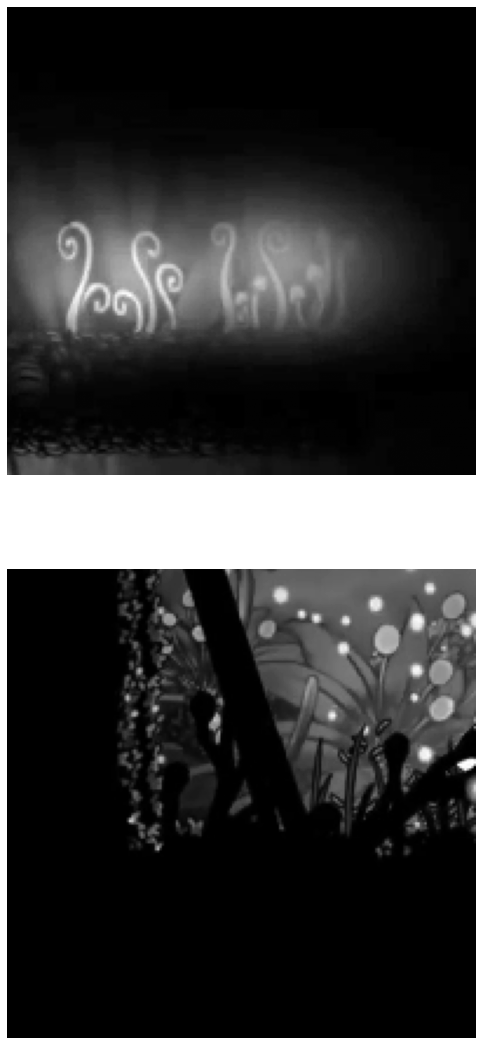

In [5]:
plt.figure(figsize=(50, 50))
images = next(train_ds_prep)
for i, image in enumerate(images[0][:2]):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(image)
    plt.axis("off")

train_ds.reset()

In [264]:
import tensorflow
from tensorflow.keras import mixed_precision
from tensorflow.keras import backend as K, losses
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ZeroPadding2D, Dropout, BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from keras.activations import softmax
from keras.regularizers import l2


def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(y_true, y_pred, 1.0, filter_size=3))

def create_big_compression_model_2_outdated(image_width, image_height):
    model = Sequential([
        Conv2D(input_shape=(image_width, image_height, 1), filters=16, kernel_size=(4, 4), activation='relu', padding='same'),
        MaxPooling2D((3, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        MaxPooling2D((2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        MaxPooling2D((2, 2), name='encoded', dtype='float16'),
        #Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        #MaxPooling2D((2, 2), name='encoded', dtype='float16'),

        #Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        #UpSampling2D((2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        UpSampling2D((2, 2)),
        ZeroPadding2D(((1, 0), (1, 0))),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        UpSampling2D((2, 2)),
        Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        UpSampling2D((3, 3)),
        ZeroPadding2D(((1, 1), (1, 1))),
        Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid', name='decoded'),
    ])

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

def create_mnist_compression_model_outdated(image_width, image_height):
    tensorflow.random.set_seed(0)
    inputs = Input(shape=(image_width, image_height, 1))

    # Encoder (convolutional base)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    print(("shape of encoded", K.int_shape(encoded)))



    # Decoder (upsamling)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, kernel_size=(5, 5), padding='same')(x)
    print(("shape of decoded", K.int_shape(decoded)))

    return Model(inputs, decoded)

def create_improved_baseline_model_complex_outdated(image_width, image_height):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', input_shape=(image_width, image_height, 1)))
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(Conv2D(40, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', name='encoded', dtype='float16'))
    model.add(Conv2DTranspose(40, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(ZeroPadding2D(((1, 0), (1, 0))))
    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(ZeroPadding2D(((1, 0), (1, 0))))
    model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

def create_improved_baseline_model_4x_comp(image_width, image_height):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(7, 7), strides=(2, 2), kernel_initializer='he_normal',
                     padding='same', input_shape=(image_width, image_height, 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='valid'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(name='encoded', dtype='float16'))

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(16, kernel_size=(7, 7), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), activation='sigmoid', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

def my_conv(x, filters, kernel_size=3, strides=(2, 2), padding='same', kernel_initializer='he_normal', name=None):
  x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, name=name)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

def my_convTrans(x, filters, kernel_size=3, strides=(2, 2), padding='same', kernel_initializer='he_normal', name=None):
  x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, name=name)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x


def create_improved_baseline_model_complex(image_width, image_height):
    input = Input(shape=(image_height, image_width, 1))
    x = my_conv(input, 16, kernel_size=(7, 7))
    x = my_conv(x, 32)
    x = my_conv(x, 32)
    x = Dropout(.2)(x)
    x = my_conv(x, 64, padding='valid')
    x = Dropout(.2)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='encoded', dtype='float16')(x)

    x = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal')(x)
    x = Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2DTranspose(16, kernel_size=(7, 7), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), activation='sigmoid', padding='same', name='decoded')(x)

    model = Model(input, x)

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model


def create_improved_baseline_model_complex_2(image_width, image_height):
    input = Input(shape=(image_height, image_width, 1))
    x = my_conv(input, 16, kernel_size=(7, 7))
    x = my_conv(x, 32)
    x = my_conv(x, 32)
    x = Dropout(.2)(x)
    x = my_conv(x, 64, padding='valid')
    x = Dropout(.2)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='encoded', dtype='float16')(x)

    x = my_convTrans(x, 128)
    x = my_convTrans(x, 64, padding='valid')
    x = my_convTrans(x, 32)
    x = my_convTrans(x, 16, kernel_size=(7, 7))
    x = Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), activation='sigmoid', padding='same', name='decoded')(x)

    model = Model(input, x)

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

def create_unet_tmp(image_width, image_height):
    # Encoder
    encoder_input = Input(shape=(image_width, image_height, 1))
    conv1 = my_conv(encoder_input,filters=16, kernel_size=7)
    conv2 = my_conv(conv1, filters=32)
    conv3 = my_conv(conv2, filters=64)
    encoded = my_conv(conv3, filters=32, padding='valid', name='encoded')

    encoder = Model(encoder_input, encoded)

    # Decoder
    decoder_input = Input(shape=(12, 12, 32))
    up7 = my_convTrans(decoder_input,filters=64, padding='valid')
    merge7 = concatenate([conv3, up7], axis = 3)
    up8 = my_convTrans(merge7,filters=32)
    merge8 = concatenate([conv2, up8], axis = 3)
    up9 = my_convTrans(merge8,filters=16, kernel_size=7)
    merge9 = concatenate([conv1, up9], axis = 3)
    decoded = Conv2DTranspose(1, kernel_size=3, strides=(2, 2), activation='sigmoid', padding='same')(merge9)

    decoder = Model(decoder_input, decoded)

    # Autoencoder
    auto_input = Input(shape=(image_width, image_height, 1))
    encoded = encoder(auto_input)
    decoded = decoder(encoded)
    autoencoder = Model(auto_input, decoded)

    return encoder, decoder, autoencoder

def create_unet(image_width, image_height):
    # Encoder
    encoder_input = Input(shape=(image_width, image_height, 1))
    conv1 = my_conv(encoder_input,filters=16, kernel_size=7)
    conv2 = my_conv(conv1, filters=32)
    conv3 = my_conv(conv2, filters=64)
    encoded = my_conv(conv3, filters=32, padding='valid', name='encoded')

    # Decoder
    up7 = my_convTrans(encoded,filters=64, padding='valid', name='decoder_input')
    merge7 = concatenate([conv3, up7], axis = 3)
    up8 = my_convTrans(merge7,filters=32)
    merge8 = concatenate([conv2, up8], axis = 3)
    up9 = my_convTrans(merge8,filters=16, kernel_size=7)
    merge9 = concatenate([conv1, up9], axis = 3)
    decoded = Conv2DTranspose(1, kernel_size=3, strides=(2, 2), activation='sigmoid', padding='same')(merge9)

    model = Model(encoder_input, decoded)

    return model

# mixed_precision.set_global_policy('mixed_float16')
# mixed_precision.set_global_policy('float32')

In [265]:
def split_autoencoder(autoencoder):
    # Get encoder
    encoder = Model(inputs=autoencoder.layers[0].input, outputs=autoencoder.get_layer('encoded').output)
    decoder_input = Input(shape=(12, 12, 32))
    decoder = Model(inputs=autoencoder.get_layer('decoder_input').input, outputs=autoencoder.layers[-1].output)

    return encoder, decoder

In [266]:
autoencoder = create_improved_baseline_model_4x_comp(image_width, image_height)
# encoder, decoder = split_autoencoder(autoencoder)
autoencoder.summary()

('shape of encoded', (None, 12, 12, 32))
('shape of decoded', (None, 200, 200, 1))
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_293 (Conv2D)         (None, 100, 100, 16)      800       
                                                                 
 activation_344 (Activation)  (None, 100, 100, 16)     0         
                                                                 
 batch_normalization_353 (Ba  (None, 100, 100, 16)     64        
 tchNormalization)                                               
                                                                 
 dropout_94 (Dropout)        (None, 100, 100, 16)      0         
                                                                 
 conv2d_294 (Conv2D)         (None, 50, 50, 32)        4640      
                                                                 
 activation_345 (Activation)  (None,

In [267]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss=ssim_loss)
#autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003), loss='binary_crossentropy')
# autoencoder.compile(optimizer=keras.optimizers.SGD(learning_rate=0.05), loss=ssim_loss)

In [275]:
# loss: 0.0676 - val_loss: 0.0727
# after 160 epochs - loss 0.0392

# 4x
# loss: 60 epochs - 0.1301
# loss: > 1000 epochs - 0.0784
# autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanAbsoluteError())
# autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003), loss=losses.MeanSquaredError())
autoencoder.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=30,
                verbose=1)

# autoencoder.fit(train_ds_mapped, epochs=1,
#                 validation_data=test_ds_mapped, verbose=1)

Epoch 1/30
106/106 [==============================] - 63s 592ms/step - loss: 0.0305 - val_loss: 0.0239
Epoch 2/30
106/106 [==============================] - 63s 593ms/step - loss: 0.0290 - val_loss: 0.0225
Epoch 3/30
106/106 [==============================] - 65s 605ms/step - loss: 0.0295 - val_loss: 0.0209
Epoch 4/30
106/106 [==============================] - 68s 640ms/step - loss: 0.0293 - val_loss: 0.0204
Epoch 5/30
106/106 [==============================] - 63s 590ms/step - loss: 0.0288 - val_loss: 0.0215
Epoch 6/30
106/106 [==============================] - 63s 598ms/step - loss: 0.0318 - val_loss: 0.0234
Epoch 7/30
106/106 [==============================] - 65s 614ms/step - loss: 0.0310 - val_loss: 0.0218
Epoch 8/30
106/106 [==============================] - 64s 605ms/step - loss: 0.0286 - val_loss: 0.0212
Epoch 9/30
106/106 [==============================] - 66s 623ms/step - loss: 0.0296 - val_loss: 0.0208
Epoch 10/30
106/106 [==============================] - 63s 589ms/step - l

In [278]:
# Saving the model:
# autoencoder.save('../model-saves/tmp/')

INFO:tensorflow:Assets written to: ../model-saves/conv2dtrans-4x/assets


INFO:tensorflow:Assets written to: ../model-saves/conv2dtrans-4x/assets


In [7]:
# Loading the model
# autoencoder = keras.models.load_model('../model-saves/conv2dtrans/model-save-170', custom_objects={
#     'ssim_loss': ssim_loss
# })

1/1 [==============================] - 0s 94ms/step


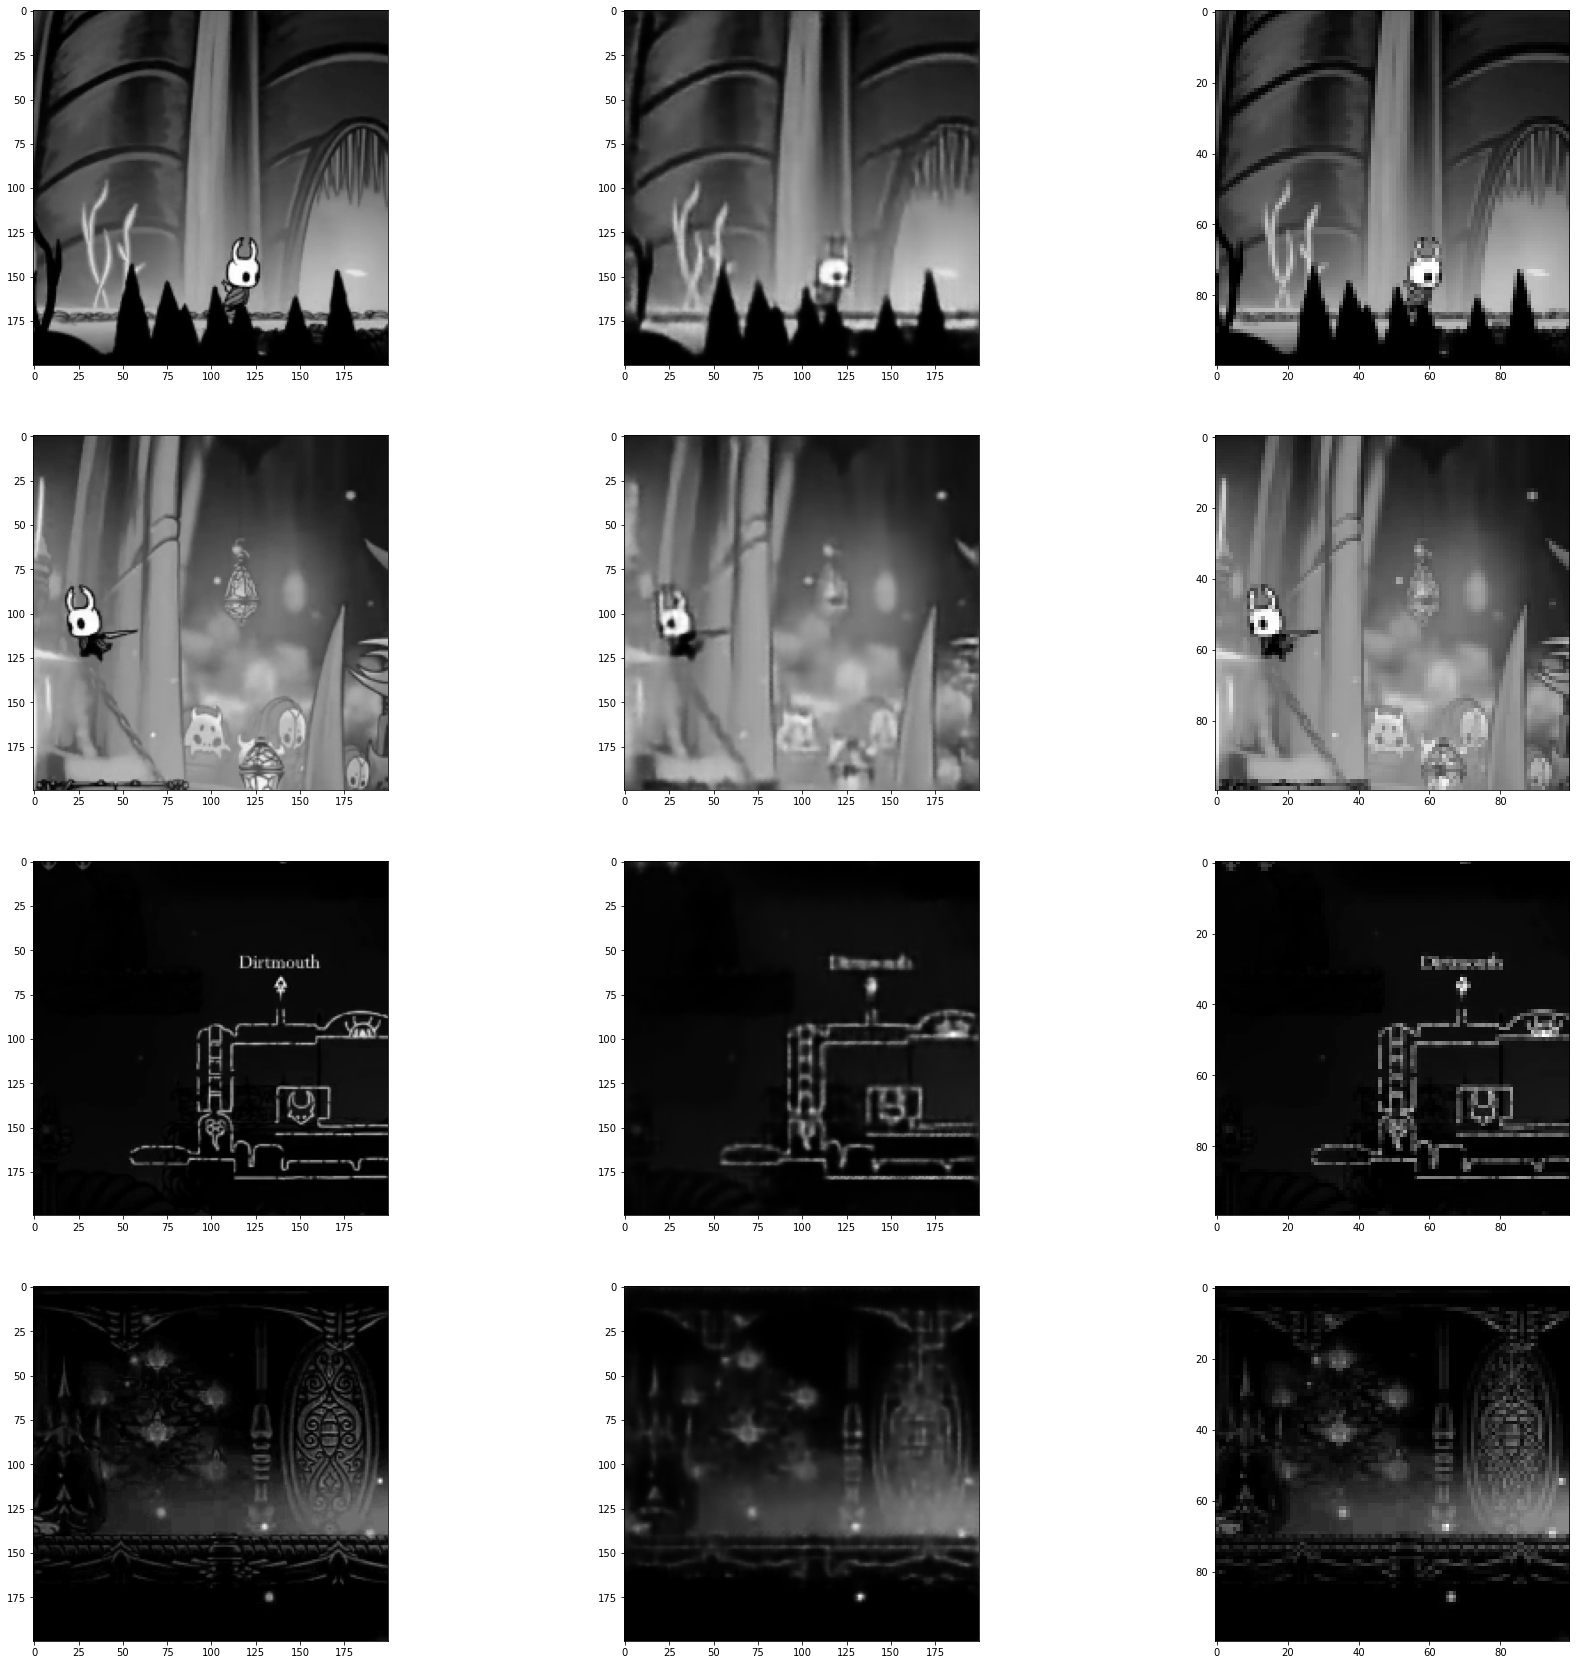

In [276]:
from matplotlib.pyplot import axes
import numpy as np

img_number = 4
test_images = next(test_ds_prep)[0][:img_number]
decoded_imgs = autoencoder.predict(test_images)

fig = plt.figure(figsize=(30, 30))

for i, in_img, out_img in zip(range(0, img_number, 1), test_images, decoded_imgs):
    plt.subplot(img_number, 3, i*3+1)
    plt.imshow(in_img)
    plt.subplot(img_number, 3, i*3 + 2)
    plt.imshow(out_img)
    plt.subplot(img_number, 3, i*3 + 3)
    rescaled_img = cv2.resize(in_img, (in_img.shape[0] // 2, in_img.shape[1] // 2))
    # manual_compression = tensorflow.cast(in_img*255. ,tensorflow.int32)
    # manual_compression = manual_compression - (manual_compression % 64)
    # manual_compression = tensorflow.cast(manual_compression ,tensorflow.float32)
    # manual_compression = tensorflow.cast(manual_compression/255. ,tensorflow.float32)
    plt.imshow(rescaled_img)
    # print(f'Image({i}) ms-ssim={ssim_loss(in_img, out_img):5.4f}, mae={np.mean(np.abs(in_img - out_img)):5.4f}, ms-ssim(manual)={ssim_loss(in_img, manual_compression):5.4f}, mae(manual)={np.mean(np.abs(in_img - manual_compression)):5.4f}')